# Main Diffusion Script
### Imports

In [2]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

General

In [3]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_maestro_v1"
training_data_name: str = "training_maestro_mel"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [4]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [5]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 1400
n_validation_samples: int = 50
tensor_dim: list = [1, 96, 512] #B, C, H = Batch, Freq bins, Time domain

batch_size: int = 64


learning_rate: float = 0.000479
betas: tuple[float] = (0.57, 0.76)
epochs: int = 1000
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [ ]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
np.random.seed(50)
np.random.shuffle(file)
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-30 13:22:47,452 - INFO - Data loaded with shape: (5000, 96, 512)


### Setup

Model Creation

Optuna

In [21]:
def define_model(trial: optuna.Trial) -> nn.Module:
    base_channels = trial.suggest_int("base_channels", 64, 256, step=32)
    channels = [base_channels, base_channels, base_channels * 2, base_channels * 2, base_channels * 4, base_channels * 4, base_channels * 4]
    attention_heads = trial.suggest_int("attention_heads", 4, 16, step=4)
    attention_features = trial.suggest_int("attention_features", 128, 512, step=64)
    factor_pattern_str = trial.suggest_categorical("factor_pattern", ["1_1_2_2_2_2_2", "1_2_2_2_2_2_2", "2_2_2_2_2_2_2"])
    items_pattern_str = trial.suggest_categorical("items_pattern", ["1_2_2_2_2_2_2", "1_1_2_2_3_3_3", "2_2_2_2_2_2_2"
    ])
    attention_pattern_str = trial.suggest_categorical("attention_pattern", ["0_0_1_1_1_1_1", "0_0_0_1_1_1_1", "0_0_0_0_1_1_1"])
    
    factor_pattern = [int(x) for x in factor_pattern_str.split("_")]
    items = [int(x) for x in items_pattern_str.split("_")]
    attention_pattern = [int(x) for x in attention_pattern_str.split("_")]
    u_net = UNetV0
    u_net = DiffusionModel(
        net_t=u_net,
        in_channels=96,
        channels=channels,
        factors=factor_pattern,
        items=items,
        attentions=attention_pattern,
        attention_features=attention_features,
        attention_heads=attention_heads,
        diffusion_t=VDiffusion,
        sampler_t=VSampler,
        dim=1
    )
    return u_net

def objective(trial: optuna.Trial) -> float:
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
    b1 = trial.suggest_float("b1", 0.4, 0.99)
    b2 = trial.suggest_float("b2", 0.4, 0.999)
    model = define_model(trial).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))

    data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
    validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
    
    n_epochs = 10
    if device == "cuda":
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = torch.amp.GradScaler(device=device)

    best_val_loss: float = float('inf')
    for e in range(n_epochs):
        total_loss: float = 0
        validation_loss: float = 0

        for b_idx, (x, _) in enumerate(data_loader):
            if x.dim() == 2:
                x = x.to(device).unsqueeze(1)
            else:
                x = x.to(device)
            with torch.autocast(device_type=device):
                loss = model(x)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        if validation_dataloader is not None:
            model.eval()
            for (x, _) in validation_dataloader:
                if x.dim() == 2:
                    x = x.to(device).unsqueeze(1)
                else:
                    x = x.to(device)
                with torch.no_grad():
                    loss = model(x)
                    validation_loss += loss.item()
            validation_loss /= len(validation_dataloader)
            model.train()

        total_loss /= len(data_loader)
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
        trial.report(validation_loss, e)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return best_val_loss

def run_optim(n_trials: int, name: str ="main_study") -> None:
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(),study_name=name)
    study.optimize(objective, n_trials=n_trials)
    logger.info("Finished Study")
    logger.info(f"Best trial: {study.best_trial} with value: {study.best_trial.value} using params:")
    for key, val in study.best_trial.params.items():
        logger.info(f"{key}:{val}")
    
    logger.info("Param importance:")
    for param, importance in get_param_importances(study).items():
            logger.info(f"{param}: {importance:.4f}")
    fig = plot_param_importances(study)
    fig.show()


In [22]:
run_optim(n_trials=150)

[I 2025-06-30 13:40:29,502] A new study created in memory with name: main_study
[I 2025-06-30 13:42:22,747] Trial 0 finished with value: 0.08499068208038807 and parameters: {'lr': 0.0004249370993382489, 'batch_size': 16, 'b1': 0.4714375599289904, 'b2': 0.947407900121802, 'base_channels': 192, 'attention_heads': 12, 'attention_features': 192, 'factor_pattern': '1_2_2_2_2_2_2', 'items_pattern': '1_2_2_2_2_2_2', 'attention_pattern': '0_0_0_1_1_1_1'}. Best is trial 0 with value: 0.08499068208038807.
[I 2025-06-30 13:42:56,279] Trial 1 finished with value: 0.3511846959590912 and parameters: {'lr': 0.00013777702711846584, 'batch_size': 56, 'b1': 0.8491811583840979, 'b2': 0.7571572657179305, 'base_channels': 96, 'attention_heads': 12, 'attention_features': 128, 'factor_pattern': '2_2_2_2_2_2_2', 'items_pattern': '1_2_2_2_2_2_2', 'attention_pattern': '0_0_1_1_1_1_1'}. Best is trial 0 with value: 0.08499068208038807.
[I 2025-06-30 13:44:12,582] Trial 2 finished with value: 0.33897056182225543 a

In [ ]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=96,
    channels=[128, 128, 256, 256, 512, 512, 512],
    factors=[1, 1, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2, 2],
    attentions=[0, 0, 1, 1, 1, 1, 1],
    attention_features=256,
    attention_heads=12,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=1
).to(device)


Model Loading

In [18]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-06-30 13:35:26,048 - INFO - Model diffusion_maestro_v1 created with ~7.902M Parameters


Initiate Trainer

In [ ]:
trainer = DiffusionTrainer(u_net, optimizer, scheduler, device, n_dims=1)

### Training

In [20]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=500,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=20,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

2025-06-30 13:35:30,645 - INFO - Training started on cuda
2025-06-30 13:35:39,503 - INFO - Epoch 001: Avg. Loss: 6.48624e-01 Avg. val. Loss: 4.53784e-01 Remaining Time: 01h 13min 35s LR: 4.69420e-04 
2025-06-30 13:35:47,912 - INFO - Epoch 002: Avg. Loss: 3.62262e-01 Avg. val. Loss: 3.30306e-01 Remaining Time: 01h 11min 36s LR: 4.60032e-04 
2025-06-30 13:35:56,329 - INFO - Epoch 003: Avg. Loss: 2.29305e-01 Avg. val. Loss: 2.71232e-01 Remaining Time: 01h 10min 52s LR: 4.50831e-04 
2025-06-30 13:36:04,784 - INFO - Epoch 004: Avg. Loss: 1.83565e-01 Avg. val. Loss: 1.68069e-01 Remaining Time: 01h 10min 31s LR: 4.41814e-04 
2025-06-30 13:36:13,237 - INFO - Epoch 005: Avg. Loss: 1.58291e-01 Avg. val. Loss: 1.57757e-01 Remaining Time: 01h 10min 14s LR: 4.32978e-04 
2025-06-30 13:36:21,729 - INFO - Epoch 006: Avg. Loss: 1.45264e-01 Avg. val. Loss: 1.63150e-01 Remaining Time: 01h 10min 04s LR: 4.24319e-04 
2025-06-30 13:36:30,223 - INFO - Epoch 007: Avg. Loss: 1.33202e-01 Avg. val. Loss: 1.34937

RuntimeError: Given groups=1, weight of size [8, 1, 1, 1], expected input[2, 64, 96, 512] to have 1 channels, but got 64 channels instead

Save Model Architecture

In [ ]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

### Sample

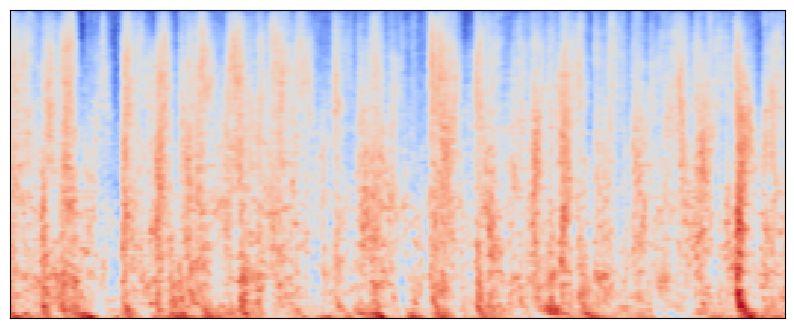

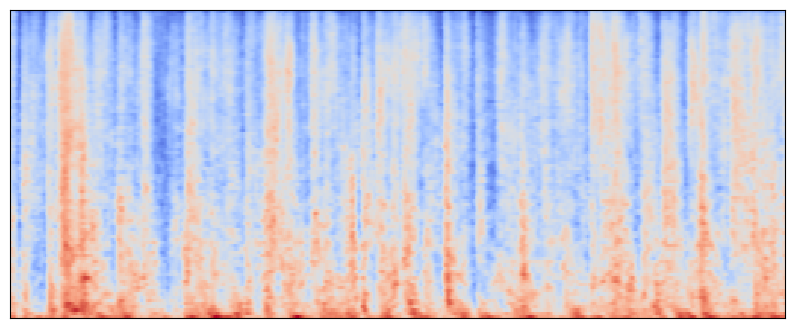

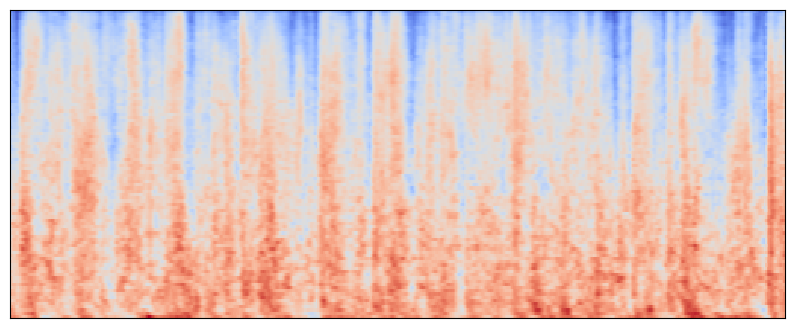

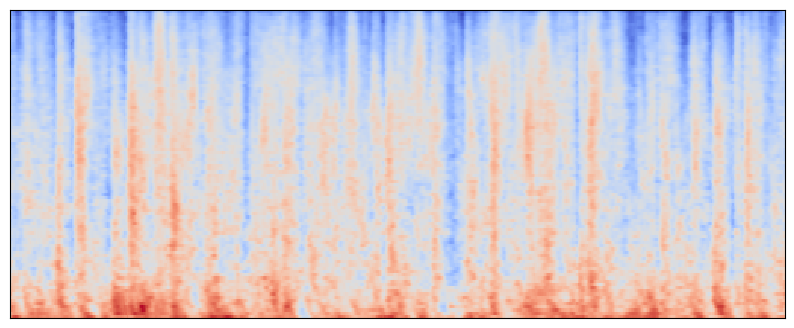

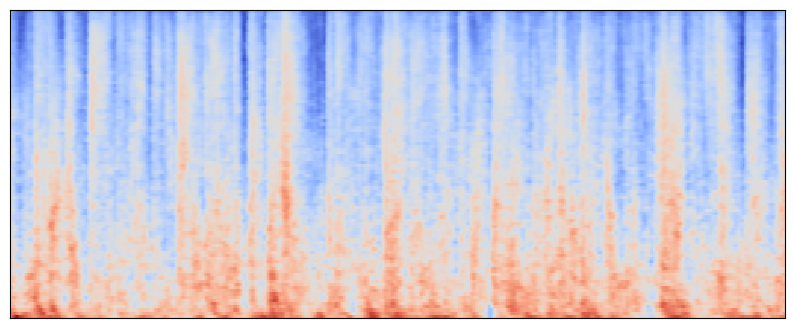

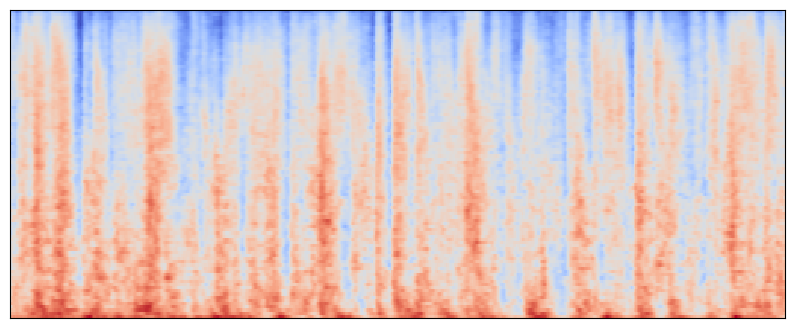

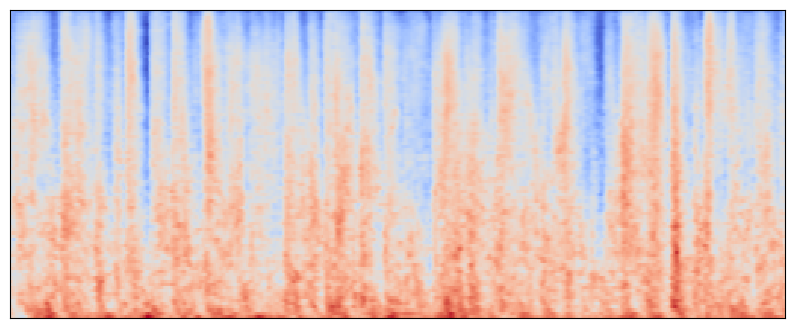

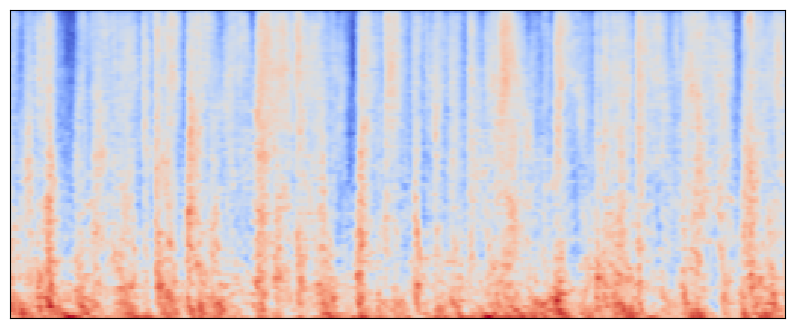

(8, 96, 512) 0.24606788 0.0034354804 0.37101647 -0.13695227


In [9]:
samples = trainer.sample(8, tensor_dim, 100, True)
print(samples.shape, samples.std(), samples.mean(), file.std(), file.mean())

In [ ]:
for i in range(samples.shape[0]):
    save_audio_file(librosa.feature.inverse.mel_to_audio(samples[i], n_fft=1023, hop_length=256, sr=32000,n_iter=300), "test_v3_{}.wav".format(i), sr=32000)

In [30]:
save_spectrogram(samples[0], "spect_1")

Save Samples

In [ ]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

Evaluate

In [ ]:
trainer.get_audio_metrics(samples, file)

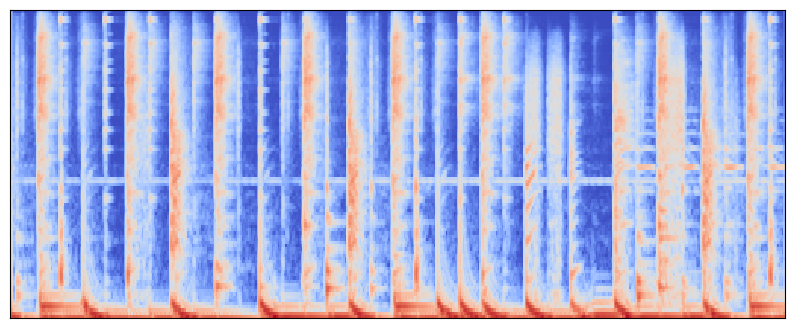

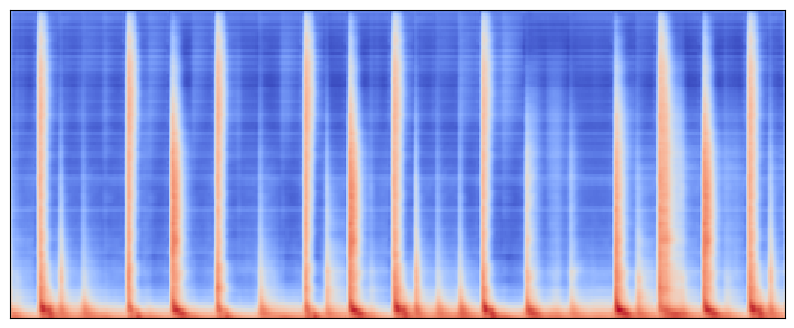

In [ ]:
visualize_spectrogram(file[100], sr=32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(file[100], n_fft=1023, hop_length=256, sr=32000), "test_inference_orig.wav", sr=32000)
out = u_net.sample(torch.tensor(file[100]).unsqueeze(0).to(device), num_steps=1000).cpu().numpy()[0]
visualize_spectrogram(out, sr=32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(out, n_fft=1023, hop_length=256, sr=32000), "test_inference.wav", sr=32000)